In [13]:
import os
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
from mlflow.models import infer_signature

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from mlflow import log_metric, log_param, log_artifacts

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import itertools

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
data = pd.read_csv("data/2024-06-25_17-30-54_unscaled_MinimalPreprocessing.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()
datasetname = '2024-06-25_17-30-54_unscaled_MinimalPreprocessing.csv'

Number of datapoints: 2216


In [43]:
#Scaling
max_abs_scaler = MaxAbsScaler()
data_maxabs = max_abs_scaler.fit_transform(data)

# Building the Model
* DBSCAN

In [44]:
def plot_k_distance(data, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, min_samples-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{min_samples}-distance')
    plt.show()

In [45]:
len(data.columns)

29

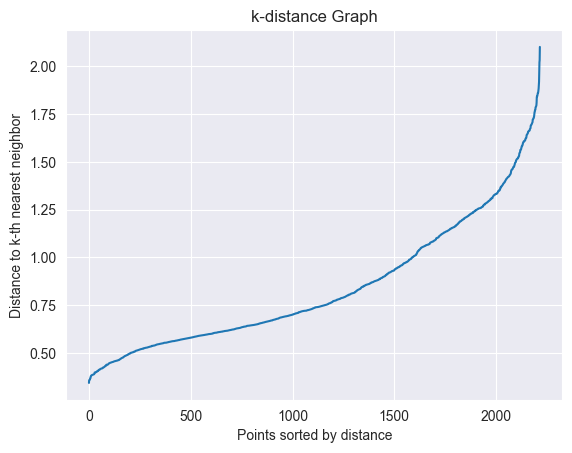

In [46]:
min_samples = ( len(data.columns) * 2 )# or a value in the range of 50-70
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data_maxabs)
distances, indices = nbrs.kneighbors(data_maxabs)

# Sort the distances to the k-th nearest neighbor (index min_samples-1)
distances = np.sort(distances[:, min_samples - 1])

# Plot the sorted k-distances
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.title('k-distance Graph')
plt.savefig('k_distance_graph.png')
plt.show()


In [47]:
def evaluate_k_clustering(data, combination, k):
    X = data[list(combination)]
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin_avg = davies_bouldin_score(X, labels)
    return silhouette_avg, davies_bouldin_avg

In [48]:
def evaluate_dbscan_clustering(data, eps, min_samples):
    X = data
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    labels = dbscan.fit_predict(X)
    unique_labels = set(labels)
    
    if len(unique_labels) > 1:
        silhouette_avg = silhouette_score(X, labels)
        davies_bouldin_avg = davies_bouldin_score(X, labels)
        n_clusters = len(unique_labels)
    else:
        silhouette_avg = -1  
        davies_bouldin_avg = -1
        n_clusters = - 1
    return silhouette_avg, davies_bouldin_avg, n_clusters

In [49]:
# Function to log experiment details to MLflow for k means
def log_dbscan_experiment(combination, silhouette_avg, davies_bouldin_avg, eps, min_samples, n_clusters):
    dataset: PandasDataset = mlflow.data.from_pandas(data)
    run_name = f"DBSCAN_eps={eps}_min_samples={min_samples}_n_clusters={n_clusters}_scaled"
    with mlflow.start_run(run_name=run_name, experiment_id='759253670368597458'):
        mlflow
        mlflow.log_input(dataset)
        mlflow.log_param("dataset", datasetname)
        mlflow.log_param("min_samples", min_samples)
        mlflow.log_param("eps", eps)
        mlflow.log_param("features", combination)
        mlflow.log_metric("silhouette_score", silhouette_avg)
        mlflow.log_metric("n-cluster", n_clusters)
        mlflow.log_metric("davies_bouldin_score", davies_bouldin_avg)
        mlflow.set_tag("algorithm", "dbscan")

In [50]:
def plot_cardinality_cluster_dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    labels = dbscan.fit_predict(data)
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        n_clusters = len(set(labels)) 
        n_noise = list(labels).count(-1)    
    
    cardinality = [list(labels).count(label) for label in unique_labels]
    clusters = ['Noise' if label == -1 else f'Cluster {label}' for label in unique_labels]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=clusters, y=cardinality)
    plt.title('Cardinality of Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Points')
    plt.show()

In [53]:
# common approach 2 * number of features
min_samples_value = len(data.columns) * 2
eps_values = np.arange(1, 1.51, 1)

combination = data.columns

for eps in eps_values:
    silhouette_avg, davies_bouldin_avg, n_clusters = evaluate_dbscan_clustering(data_maxabs, eps, min_samples_value)
    log_dbscan_experiment(combination,  silhouette_avg, davies_bouldin_avg, eps, min_samples, n_clusters)
    print(f"Logged with dbscan with min_samples={min_samples} and eps={eps} with {n_clusters} Cluster")

Logged with dbscan with min_samples=58 and eps=1.0 with 4 Cluster


/Users/felixwissel/miniconda3/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


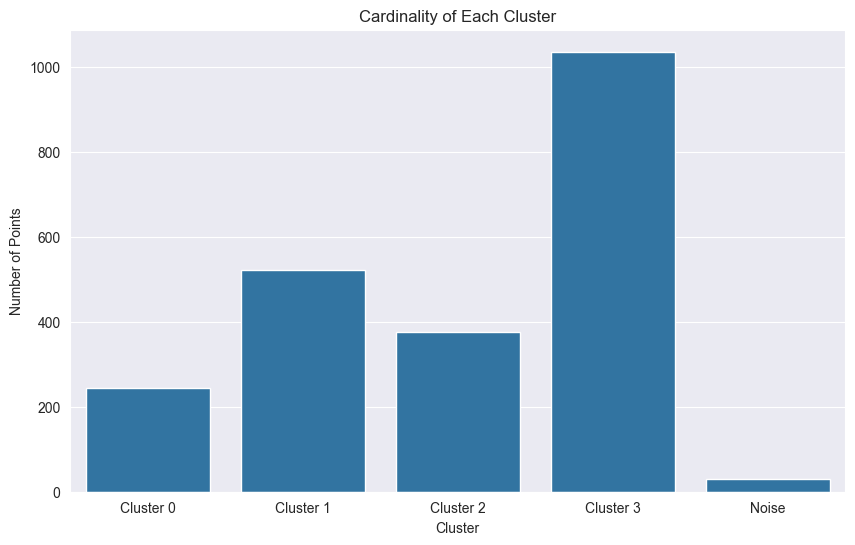

In [25]:
plot_cardinality_cluster_dbscan(data_maxabs, 0.975, len(data.columns) * 2)

In [26]:
print("Clustering evaluation completed and logged to MLflow.")

Clustering evaluation completed and logged to MLflow.


In [27]:
eps = 0.975
min_samples = len(data.columns) * 2
dbscan = DBSCAN(eps = eps, min_samples = min_samples)
data['Cluster'] = dbscan.fit_predict(data_maxabs)
clusters = data['Cluster'].unique()

In [28]:
cluster_dfs = {}
for cluster in clusters:
    cluster_dfs[cluster] = data[data['Cluster'] == cluster].reset_index(drop=True)

In [29]:
len(clusters)

5

In [30]:
cluster_0_df = cluster_dfs[0]
cluster_1_df = cluster_dfs[1]
cluster_2_df = cluster_dfs[2]
cluster_3_df = cluster_dfs[3]

In [31]:
for column in cluster_0_df.columns:
    unique_count = cluster_0_df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")

Number of unique values in column 'ID': 244
Number of unique values in column 'Income': 223
Number of unique values in column 'Dt_Customer': 183
Number of unique values in column 'Recency': 88
Number of unique values in column 'MntWines': 192
Number of unique values in column 'MntFruits': 103
Number of unique values in column 'MntMeatProducts': 192
Number of unique values in column 'MntFishProducts': 116
Number of unique values in column 'MntSweetProducts': 112
Number of unique values in column 'MntGoldProds': 120
Number of unique values in column 'NumDealsPurchases': 4
Number of unique values in column 'NumWebVisitsMonth': 11
Number of unique values in column 'Complain': 1
Number of unique values in column 'Age': 54
Number of unique values in column 'Marital_Categories': 1
Number of unique values in column 'Edu_Categories': 4
Number of unique values in column 'Spent_Total': 209
Number of unique values in column 'Living_Alone': 1
Number of unique values in column 'Having_Kids': 1
Numbe

In [32]:
income_medians = {
    'Cluster 0': cluster_0_df['Income'].median(),
    'Cluster 1': cluster_1_df['Income'].median(),
    'Cluster 2': cluster_2_df['Income'].median(),
    'Cluster 3': cluster_3_df['Income'].median()
}
age_medians = {
    'Cluster 0': cluster_0_df['Age'].median(),
    'Cluster 1': cluster_1_df['Age'].median(),
    'Cluster 2': cluster_2_df['Age'].median(),
    'Cluster 3': cluster_3_df['Age'].median()
}

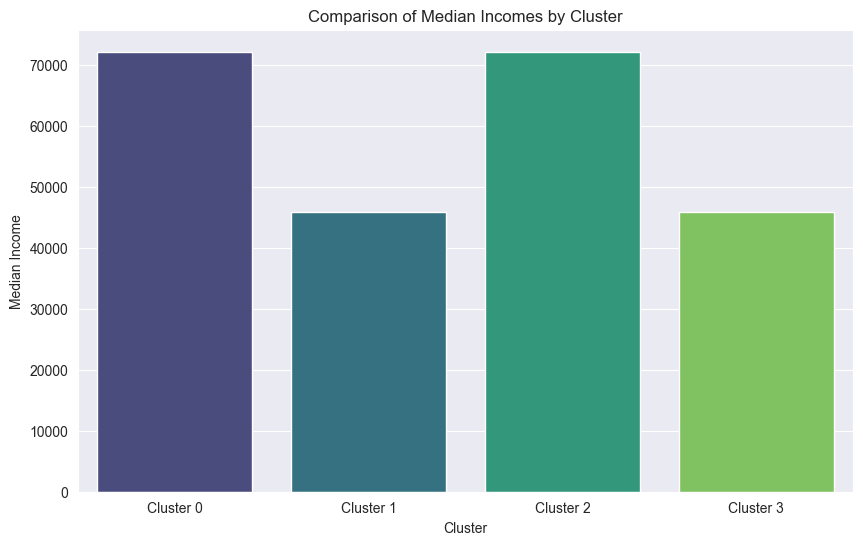

In [33]:
income_medians_df = pd.DataFrame(list(income_medians.items()), columns=['Cluster', 'Median Income'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Income', data=income_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Incomes by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Income')
plt.show()

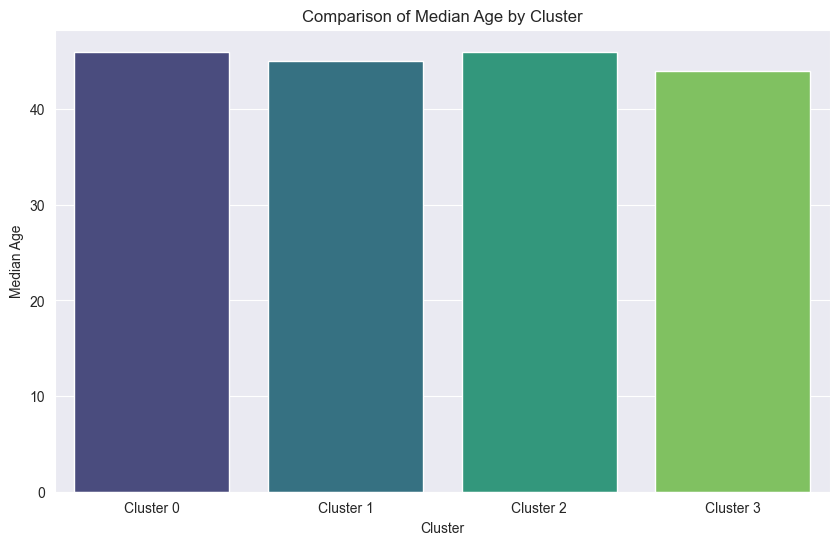

In [34]:
age_medians_df = pd.DataFrame(list(age_medians.items()), columns=['Cluster', 'Median Age'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Age', data=age_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Age')
plt.show()

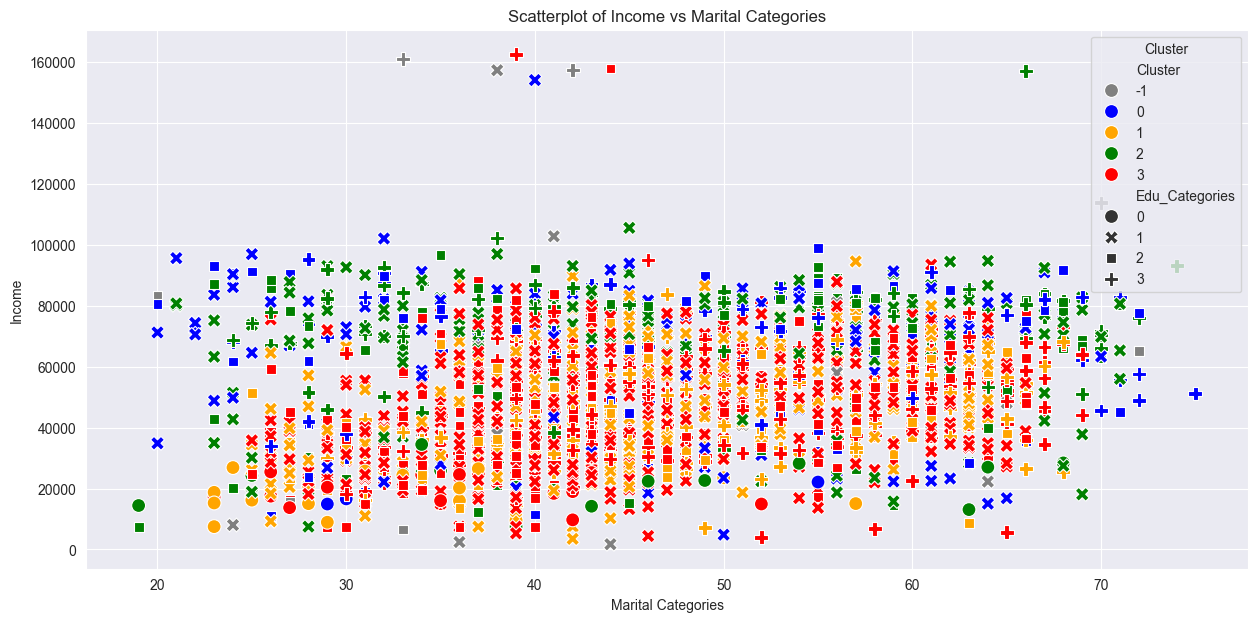

In [35]:
palette = {-1: 'gray', 0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Age', y='Income', hue='Cluster',  style='Edu_Categories', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Marital Categories')
plt.xlabel('Marital Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

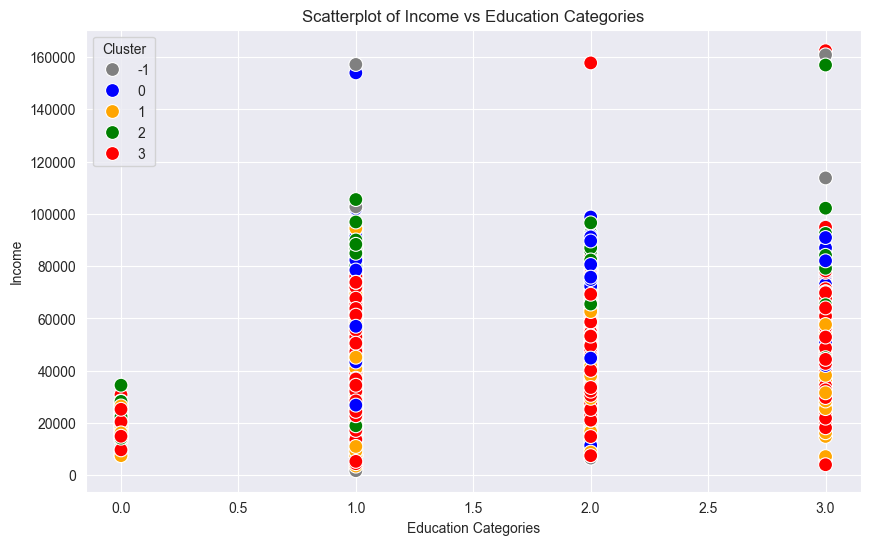

In [36]:
palette = {-1: 'gray', 0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Edu_Categories', y='Income', hue='Cluster', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Education Categories')
plt.xlabel('Education Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

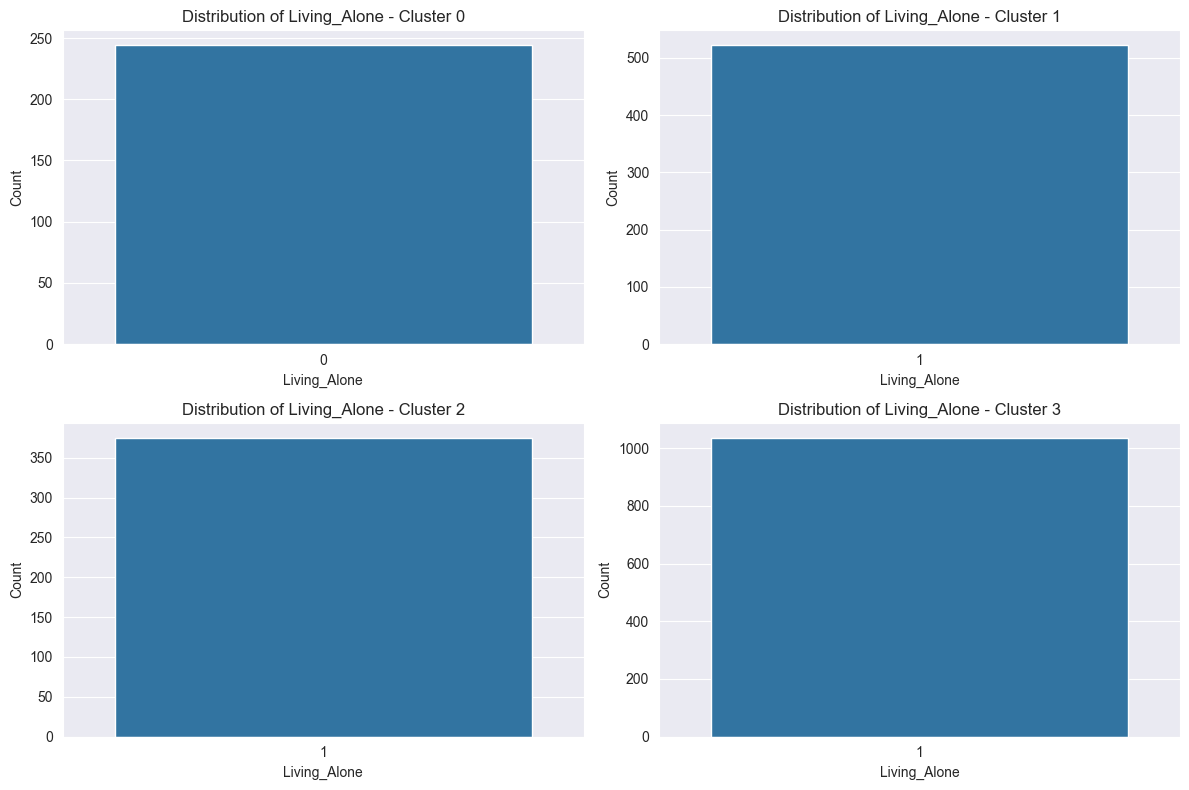

In [37]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='Living_Alone', data=df)
    plt.title(f'Distribution of Living_Alone - Cluster {i}')
    plt.xlabel('Living_Alone')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


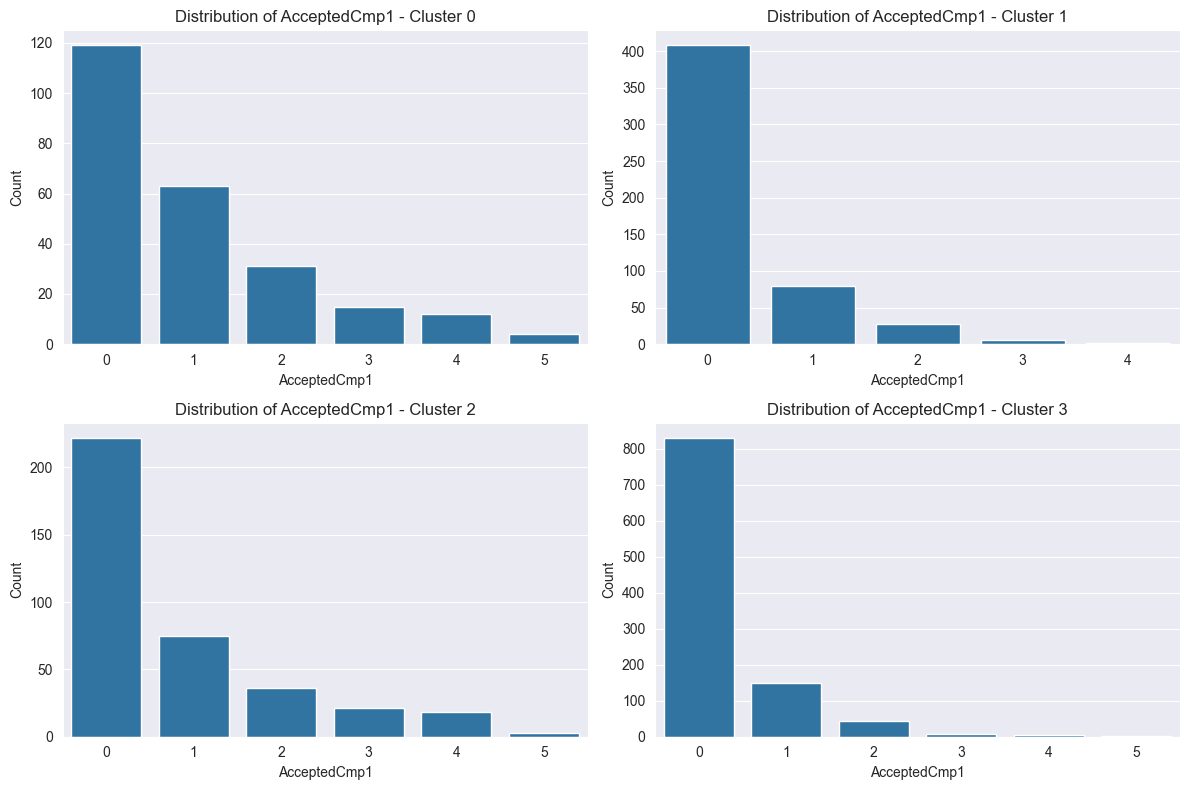

In [38]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='AcceptedOffer', data=df)
    plt.title(f'Distribution of AcceptedCmp1 - Cluster {i}')
    plt.xlabel('AcceptedCmp1')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

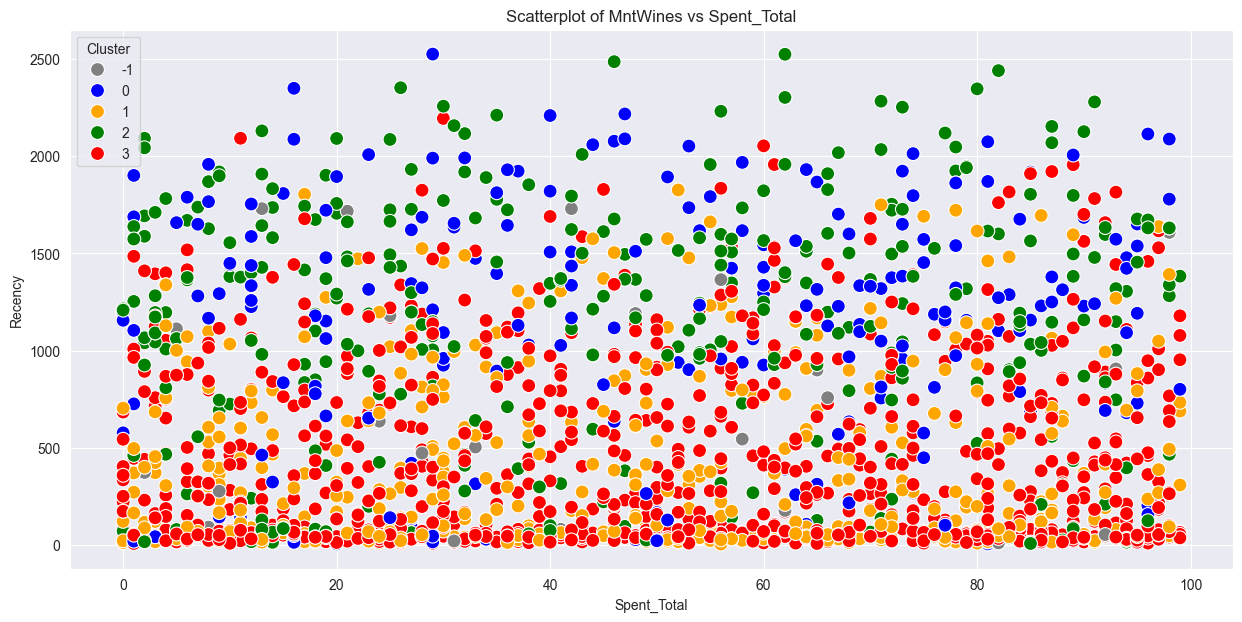

In [39]:
palette = {-1: 'gray', 0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Recency', y='Spent_Total', hue='Cluster', data=data, palette=palette, s=100)
plt.title('Scatterplot of MntWines vs Spent_Total')
plt.xlabel('Spent_Total')
plt.ylabel('Recency')
plt.legend(title='Cluster')

plt.show()

In [40]:
# Assuming your dataframes are named cluster_0_df, cluster_1_df, cluster_2_df, and cluster_3_df
clusters = [cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]

# List of column names
columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Create a list to hold the median data for each cluster
median_data = []

# Calculate medians for each cluster and sum of medians
for i, cluster_df in enumerate(clusters):
    medians = cluster_df[columns].median()
    medians['Total'] = medians.sum()  # Add a column for the sum of the medians
    median_data.append(medians)

# Create a DataFrame from the median data
median_df = pd.DataFrame(median_data, index=[f'Cluster {i}' for i in range(len(clusters))])

# Melt the DataFrame for easy plotting with seaborn
median_df_melted = median_df.reset_index().melt(id_vars='index', var_name='PurchaseType', value_name='MedianValue')
median_df_melted.rename(columns={'index': 'Cluster'}, inplace=True)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='PurchaseType', y='MedianValue', hue='Cluster', data=median_df_melted)

# Adding titles and labels
plt.title('Median Values of Purchases and Total for Each Cluster')
plt.xlabel('Purchase Type')
plt.ylabel('Median Value')

# Show the plot
plt.show()


KeyError: "None of [Index(['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], dtype='object')] are in the [columns]"

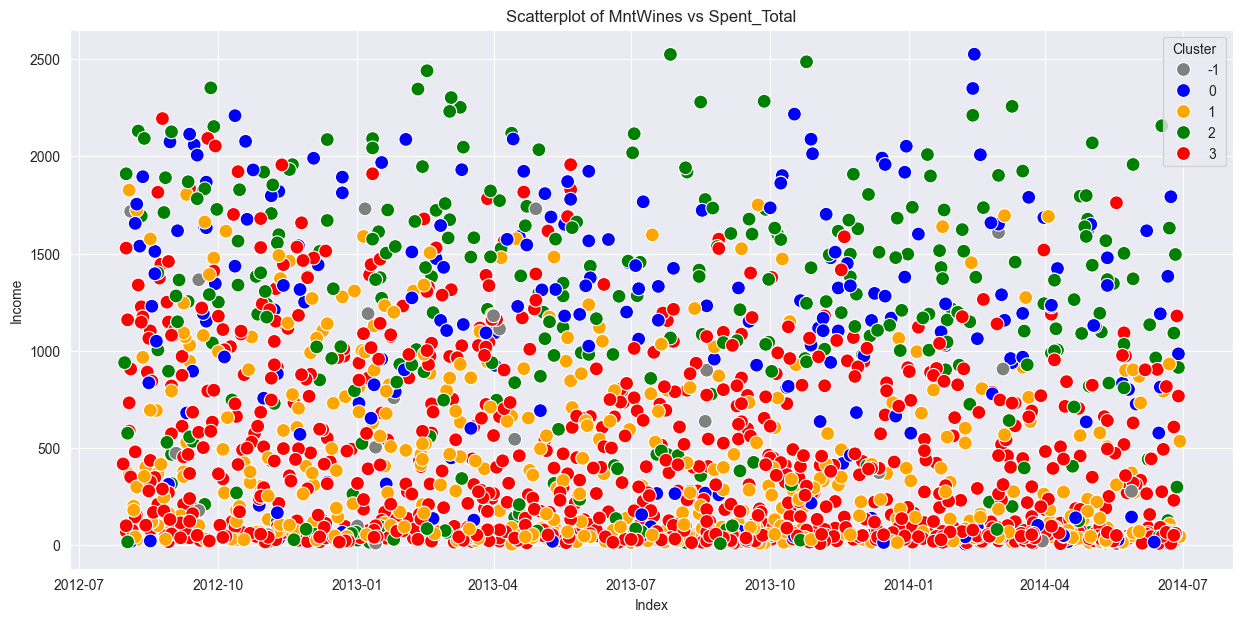

In [41]:
palette = {-1: 'gray', 0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
data['Dt_Customer'] = data['Dt_Customer'].apply(lambda x: pd.Timestamp.fromordinal(x))
# Verify the conversion
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Dt_Customer', y='Spent_Total', hue='Cluster', data=data, palette=palette, s=100)
plt.title('Scatterplot of MntWines vs Spent_Total')
plt.xlabel('Index')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()